Alanine dipeptide
=========

In this notebook we study the rare-event kinetics of the alanine dipeptide molecule using Markov state models (MSM). Alanine-dipeptide is an example for a small peptide exhibiting rare-events in solution at room temperature. The $\phi$ and $\psi$ dihedral angles of the molecule have been identified as the two relevant coordinates for the slowest kinteic processes of the system under equilibrium conditions. Five meta-stable conformations have been identified for alanine dipeptide, $C_5$, $P_{II}$, and $\alpha_R$ are the three most probable conformations, while $\alpha_L$ and $C_7^{ax}$ are extremely rare. 

We focuss our study on the rare $C_5 \to \alpha_L$ transitions. We are interested in estimating the value of the mean first-passage time (mfpt) $\tau(C_5 \to \alpha_L)$ for this transition from simulation data via MSMs. We show that the rare-event kinetics for this molecule can be efficiently estimated if short relaxation trajectories and the stationary vector are combined using reversible MSMs. 

The short trajectories are started in the low-probability $\alpha_L$-conformation and rapidly relax to the high-probability region. The stationary vector has been estimated from umbrella sampling simulations using the weighted histogram analysis method (WHAM).

We compare the estimated values with those obtained from an ensemble of long trajectories using the standard approach (non-reversible MSM, no additional information about stationary probabilities) and show that the mfpt-value can be reliably estimated with much smaller total simulation effort if additional knowledge about the stationary probabilities is available during MSM estimation.

We carry out a full Bayesian posterior analysis to quantify the uncertainties of all estimates and show that almost one order of magnitude speedup can be achieved if short relaxation trajectories are used in combination with umbrella sampling simulations.

We start with a few general imports and settings

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as image
from pyemma import msm
from scipy.interpolate import griddata

Spatial discretisation
-------------------------
To carry out MSM analysis we need to discretize the continous conformation space into finitely many non-overlapping sets. The trajectory of continous $\phi$ and $\psi$ dihedral angle values is then converted to a trajectory of integer labels associated to the set-based discretisation of conformation space.

We have discretized the $(\phi, \psi)$ dihedral angle space, $[-180^{\circ}, 180^{\circ}] \times [-180^{\circ}, 180^{\circ}]$ , into $20 \times 20$ equal sized bins. 

In [2]:
centers = np.load('data/centers.npy')

Lagtime for MSM estimation
------------------------------

The representation of the Markovian dynamics in full conformation space in terms of the jump process on the set-based discretisation of the $(\phi, \psi)$ dihedral angle space introduces memory effects. The discrete state-space dynamics can be described by a Markov chain on a finite state space if it is viewed at an appropriate lagtime $\tau$. A good choice of lagtime allows for the decay of all processes that happen on scales not resolved by the choice of coordinate and discretisation, so that the resulting dynamics is approximately Markovian again. Both the discretization and the lag time are crucial for the approximation quality of a Markov state model [1,2].

We use a lagtime of $\tau=6ps$.

In [3]:
tau = 6

MSM from long trajectories
------------------------------
At first we build a standard Markov model (non-reversible, no additional information about stationary probabilities) from a set of $N=51$ trajectories of lenght $L=200ns $ saved at a timestep of $1 ps$. 

In order for the MSM to correctly compute the mfpt for the $C_5 \to \alpha_L$ transition the used trajectories need to contain sufficiently many rare-events. We use a total of $10\mu s$ of simulation data.

We show an overlay of the largest kinetically connected set (blue) and all centers of the discretisation (gray).The set Some regions in the $(\phi, \psi)$ dihedral angle space have extremely low probability so that there is no kinetic connection to them in the data.

Then we compute the stationary vector and the corresponding free energy (potential of mean force) and plot contour lines of the free energy. For plotting purposes we extrapolate the values on those grid centers belonging to the largest connected set to a fine grid. There might be some artifacts because the extrapolation is not aware of the $(\phi, \psi)$-periodicity and because of missing values outside of the largest connected set.

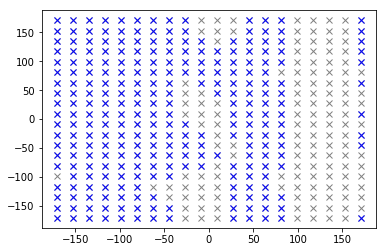

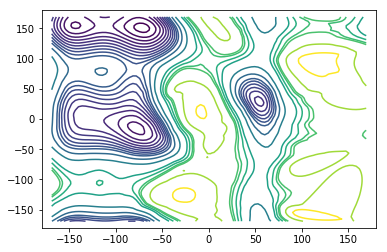

In [4]:
dtrajs_long = list(np.load('data/dtrajs_long.npz')['arr_0'])
msm_nrev = msm.estimate_markov_model(dtrajs_long, tau, count_mode='sample')
lcc = msm_nrev.active_set
pi = msm_nrev.stationary_distribution
kB=8.314472471220217*1e-3  # kJ/(K*mol)
T=300.0                    # K
beta=1.0/(kB*T)            # mol/kJ    
A = -1.0/beta*np.log(pi)
A -= A.min()
centers_lcc = centers[lcc, :]
nx = 100
x = np.linspace(-180.0, 180.0, nx)
ny = 100
y = np.linspace(-180.0, 180.0, ny)
X, Y = np.meshgrid(x, y)
AXY = griddata(centers_lcc, A, (X, Y), method='cubic')

plt.plot(centers[:, 0], centers[:, 1], ls=' ', marker='x', c='gray')
plt.plot(centers[lcc, 0], centers[lcc, 1], ls=' ', marker='x', c='b')

levels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 22, 24, 25, 30, 35]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, AXY, levels)

Mean first-passage time computations
------------------------------------------

We are interested in the mean-first passage time (mfpt) between the two meta-stable sets,

$$ A = \{(\phi, \psi) | -162 \leq \phi \leq -108, \; 108 \leq \psi \leq 180 \}$$

and 

$$ B = \{(\phi, \psi) | 36 \leq \phi \leq 72, \; -18 \leq \psi \leq 72 \}$$

also known as the $C_5$ and $\alpha_L$ conformations.

Maximum likelihood value from a total of 10 microseconds of simulation effort
mfpt of A->B transition: 43.6ns
mfpt of B->A transition: 1.5ns


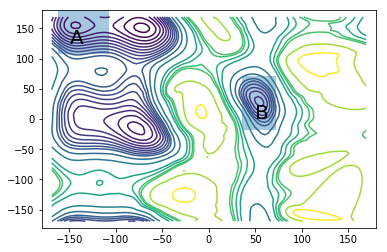

In [5]:
def compute_set_indices(centers_raw, lcc):
    centers = centers_raw[lcc, :]
    ix = np.logical_and( (centers[:, 0] >=-162), (centers[:, 0] <= -108) )
    iy = np.logical_and( (centers[:, 1] >= 108), (centers[:, 1] <= 180) )
    ind = np.logical_and(ix, iy)
    A = np.where(ind)[0]

    ix = np.logical_and( (centers[:, 0] >= 36), (centers[:, 0] <= 72) )
    iy = np.logical_and( (centers[:, 1] >= -18), (centers[:, 1] <= 72) )
    ind = np.logical_and(ix, iy)
    B = np.where(ind)[0]
    return A, B

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, AXY, levels)
ax.add_patch(patches.Rectangle((-162, 108), 54, 72, alpha=0.4))
ax.add_patch(patches.Rectangle((36, -18), 36, 90, alpha=0.4))
ax.annotate("A", (-150, 125), size=20)
ax.annotate("B", (50, 0), size=20)
A, B = compute_set_indices(centers, lcc)
print("Maximum likelihood value from a total of 10 microseconds of simulation effort")
print("mfpt of A->B transition: %.1fns" %(msm_nrev.mfpt(A, B)/1000))
print("mfpt of B->A transition: %.1fns" %(msm_nrev.mfpt(B, A)/1000))

Computing errors
-------------------
To quantify the uncertainty of the estimated mfpt we need to carry out a Bayesian posterior analysis, c.f. [3].

We draw transition matrices from the posterior ensemble and compute the mfpt for each sampled transition matrix. The errors of our estimate can than assessed by the sample standard deviation.

In [6]:
bmsm = msm.bayesian_markov_model(dtrajs_long, tau, count_mode='sample', reversible=False)
print("The estimated sample mean is %.2f ns" %(bmsm.sample_mean("mfpt", A, B)/1000))
print("The estimated sample standard deviation is %.2f ns" %(bmsm.sample_std("mfpt", A, B)/1000))
print("The relative error of the estimate is %.1f" %(100.0*bmsm.sample_std("mfpt", A, B)/bmsm.sample_mean("mfpt", A, B)) +"%")

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

The estimated sample mean is 43.43 ns
The estimated sample standard deviation is 2.33 ns
The relative error of the estimate is 5.4%


MSM with fixed stationary vector and short 'downhill' trajectories
----------------------------------------------------------------------------
Estimates of the stationary probabilities can be obtained from enhanced sampling simulations using appropriate reweighting techniques (WHAM, MBAR, TRAM). The amount of data required to obtain reliable estimates can be orders of magnitude smaller than those required to obtain a good estimate from data generated using a standard simulation protocol, e.g. standard MD.

There is an additional cost for the enhanced sampling simulations. The obtained estimates also come with a statistical uncertainty which can be quantified using bootstrap resampling techniques.

We use a stationary vector obtained from $100ns$ of umbrella sampling simulations and a set of $40$ short trajectories starting in the $\alpha_L$ region (set $B$) to estimate the mfpt using a total of only $300ns$ of simulation time.

We also use a bootstrap sample of stationary vectors to quantify the errors resulting from the combined uncertainty of stationary vector estimate and finite amount of trajectories used.

There is only a small patch in the free-energy region that is not resolved by the umbrella sampling simulations with biasing potential on the $\phi$ dihedral angle. This region is unimportant for the mfpt-computation however. The important barrier that trajectories going from $A \to B$ need to overcome is very well resolved using only $100ns$ of umbrella sampling data.

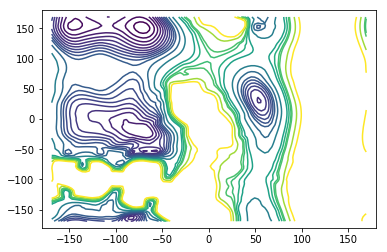

In [7]:
pi_ref = np.load('data/stationary_vector_ref.npy')
A_ref = np.zeros_like(pi_ref)
pos = (pi_ref>0.0)
npos = (pi_ref==0.0)
A_ref[pos] = -1.0/beta*np.log(pi_ref[pos])
A_ref[npos] = A_ref.max()
A_ref -= A_ref.min()
AXY = griddata(centers, A_ref, (X, Y), method='cubic')
levels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 22, 24, 25, 30, 35]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, AXY, levels)

In [8]:
dtrajs_short = list(np.load('data/dtrajs_short.npz')['arr_0'])
pi_bs = np.load('data/stationary_vector_bs.npy')[3, ::10, :]
n_bs = pi_bs.shape[0]
n_samples = 10

msm_revpi = msm.estimate_markov_model(dtrajs_short[0:40], tau, statdist=pi_ref, count_mode='sample')
A, B = compute_set_indices(centers, msm_revpi.active_set)
print("Maximum likelihood value from a total of 300 ns of simulation effort")
print("mfpt of A->B transition: %.1fns" %(msm_revpi.mfpt(A, B)/1000))
print("mfpt of B->A transition: %.1fns" %(msm_revpi.mfpt(B, A)/1000))

Maximum likelihood value from a total of 300 ns of simulation effort
mfpt of A->B transition: 39.8ns
mfpt of B->A transition: 1.4ns


Computing errors
-------------------

We again perform a Bayesian posterior analysis. Now for the ensemble of transition matrices reversible with respect to a given stationary vector, c.f. [3].

In [9]:
bmsm_revpi = msm.bayesian_markov_model(dtrajs_short[0:40], tau, statdist=pi_ref, count_mode='sample', nsamples=100)
print("The estimated sample mean is %.2f ns" %(bmsm_revpi.sample_mean('mfpt', A, B)/1000))
print("The estimated standard deviation is %.2f ns" %(bmsm_revpi.sample_std('mfpt', A, B)/1000))
print("The relative error of the estimate is %.1f" %(100.0*bmsm_revpi.sample_std('mfpt', A, B)/bmsm_revpi.sample_mean('mfpt', A, B)) +"%")

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

The estimated sample mean is 39.39 ns
The estimated standard deviation is 5.37 ns
The relative error of the estimate is 13.6%


Combined uncertainty
-----------------------
The relative error taking also into account the uncertainty in the stationary vector will be larger than the relative error taking into account only the finite amount of simulation data used.
 
We have to generate samples for each of the stationary vectors in the bootstrap, that can take a couple of minutes.

In [10]:
def sample_mfpt_bs(dtraj_list, pi_bs, n_samples, verbose=False):
    n_bs = pi_bs.shape[0]
    sample = np.zeros((n_bs*n_samples))    
    for i in range(n_bs):
        if verbose:
            print("Iteration %i of %i" %(i+1, n_bs))
        pi = pi_bs[i, :]
        bmsm_revpi = msm.bayesian_markov_model(dtraj_list, tau, statdist=pi_ref, 
                                               count_mode='sample', nsamples=n_samples, show_progress=False)
        A, B = compute_set_indices(centers, bmsm_revpi.active_set)
        sample[i*n_samples:(i+1)*n_samples] = bmsm_revpi.sample_f('mfpt', A, B)
    return sample
    
samples = sample_mfpt_bs(dtrajs_short[0:40], pi_bs, n_samples)
print("The estimated sample mean is %.2f ns" %(np.mean(samples)/1000))
print("The estimated standard deviation is %.2f ns" %(np.std(samples)/1000))
print("The relative error of the estimate is %.1f" %(100.0*np.std(samples)/np.mean(samples)) +"%")

The estimated sample mean is 41.49 ns
The estimated standard deviation is 6.66 ns
The relative error of the estimate is 16.1%


Error versus total simulation effort
-----------------------------------------

To study the uncertainty of the estimates for increasing amount of simulation data we need to estimate mean and uncertainty for an increasing number of short trajectories. Due to the large number of samples required to estimate a single data-point the evaluation of the below cells can take some time.

We have prerun the computationally heavy cells below. The resulting figures are loaded from disk, so that you do not need to wait until the results have been (re)computed. The figures have been generated using the full bootstrap sample of stationary vectors.

In [11]:
def generate_stats(dtraj_list, N_dtrajs, pi_bs, n_samples, tau):
    data = np.zeros((len(N_dtrajs), 2))
    for i in range(len(N_dtrajs)):
        print("Iteration %i of %i" %(i+1, len(N_dtrajs)))
        """Number of trajectories to use"""
        N = N_dtrajs[i] 
        sample = sample_mfpt_bs(dtraj_list[0:N], pi_bs, n_samples)
        data[i, 0] = np.mean(sample)
        data[i, 1] = np.std(sample)
    return data

def generate_stats_optimal(dtraj_list, N_dtrajs, pi_bs_list, n_samples, tau):
    data = np.zeros((len(N_dtrajs), 2))
    for i in range(len(N_dtrajs)):
        print("Iteration %i of %i" %(i+1, len(N_dtrajs)))
        """Number of trajectories to use"""
        N = N_dtrajs[i] 
        sample = sample_mfpt_bs(dtraj_list[0:N], pi_bs_list[i, :, :], n_samples)
        data[i, 0] = np.mean(sample)
        data[i, 1] = np.std(sample)
    return data

def generate_stats_nrev(dtraj_list, N_dtrajs, n_samples, tau):
    data = np.zeros((len(N_dtrajs), 2))
    for i in range(len(N_dtrajs)):
        print("Iteration %i of %i" %(i+1, len(N_dtrajs)))
        """Number of trajectories to use"""
        N = N_dtrajs[i] 
        bmsm = msm.bayesian_markov_model(dtraj_list[0:N], tau, count_mode='sample', 
                                         nsamples=n_samples, show_progress=False)
        A, B = compute_set_indices(centers, bmsm.active_set)
        sample = bmsm.sample_f('mfpt', A, B)
        data[i, 0] = np.mean(sample)
        data[i, 1] = np.std(sample)
    return data

#Subsample the stationary vector bootstrap to spped up the generation of statistics
stationary_vector_bs = np.load('data/stationary_vector_bs.npy')[:,::10,:]

In [12]:
# # Depending on n_samples this cell can take some time to run
# N_dtraj = np.array([10, 20, 50, 100, 200, 500, 1000, 1500])
# pi_bs = stationary_vector_bs[0, :, :]
# effort_short = N_dtraj *5 + 20 # N_C + N_pi in ns
# data_short = generate_stats(dtrajs_short, N_dtraj, pi_bs, n_samples, tau)

In [13]:
# # Depending on n_samples this cell can take a some time to run
# N_dtraj = np.array([10, 20, 50, 100, 200, 500, 1000, 1500])
# pi_bs = stationary_vector_bs[4, :, :]
# effort_long = N_dtraj *5 + 200 # N_C + N_pi in ns
# data_long = generate_stats(dtrajs_short, N_dtraj, pi_bs, n_samples, tau)

In [14]:
# # Depending on n_samples this cell can take a some time to run
# N_dtraj = np.array([1, 2, 5, 8, 10, 20, 30, 50])
# effort_nrev = N_dtraj*200 # N_C + N_pi in ns
# data_nrev = generate_stats_nrev(dtrajs_long, N_dtraj, n_samples*n_bs, tau)

In [15]:
# # Depending on n_samples this cell can take some time to run
# N_dtraj = np.array([8, 10, 20, 40, 100, 200, 800])
# effort_optimal = N_dtraj*5*2
# data_optimal = generate_stats_optimal(dtrajs_short, N_dtraj, stationary_vector_bs[1:, :, :], n_samples, tau)

In [16]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.set_xlabel(r"Simulation effort, $N$, in $ns$")
# ax.set_ylabel(r"Mean first-passage time, $\tau_{AB}$, in $ps$")
# ax.set_xscale('log')
# ax.set_xlim(5e1, 2e4)
# ax.axhline(43400, ls='--', c='k')
# ax.errorbar(effort_nrev, data_nrev[:, 0], yerr=data_nrev[:, 1], ls=' ', marker='^',
#            label=r"$N_{\pi}=0ns$")
# ax.errorbar(effort_short, data_short[:, 0], yerr=data_short[:, 1], ls=' ', marker='x',
#         label=r"$N_{\pi}=20ns$")
# ax.errorbar(effort_long, data_long[:, 0], yerr=data_long[:, 1], ls=' ', marker='D',
#            label=r"$N_{\pi}=200ns$")
# ax.errorbar(effort_optimal, data_optimal[:, 0], yerr=data_optimal[:, 1], ls=' ', marker='o',
#            label=r"$N_{\pi}=N_{C}$")
# ax.legend()

In [17]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.set_xlabel(r"Simulation effort, $N$, in $ns$")
# ax.set_ylabel(r"Relative error, $\epsilon(\tau_{AB})$")
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(5e1, 2e4)
# ax.plot(effort_nrev, data_nrev[:, 1]/data_nrev[:, 0], ls=':', marker='^',
#            label=r"$N_{\pi}=0ns$")
# ax.plot(effort_short, data_short[:, 1]/data_short[:, 0], ls=':', marker='x',
#         label=r"$N_{\pi}=20ns$")
# ax.plot(effort_long, data_long[:, 1]/data_long[:, 0], ls=':', marker='D',
#            label=r"$N_{\pi}=200ns$")
# ax.plot(effort_optimal, data_optimal[:, 1]/data_optimal[:, 0], ls=':', marker='o',
#            label=r"$N_{\pi}=N_{C}$")
# ax.legend()

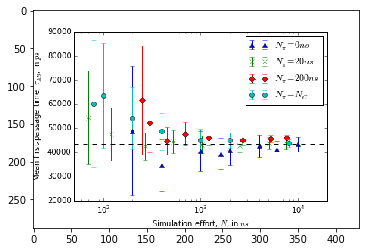

In [18]:
img1 = image.imread('expectation.png')
plt.imshow(img1)

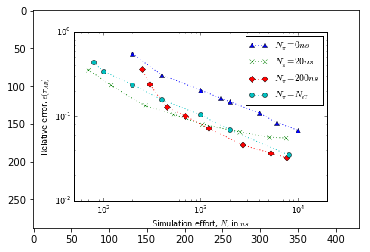

In [19]:
img2 = image.imread('error.png')
plt.imshow(img2)

References
------------

[1] Prinz, J.-H., H. Wu, M. Sarich, B. G. Keller, M. Senne, M. Held, J. D. Chodera, Ch. Schütte and F. Noé: Markov models of molecular kinetics: Generation and Validation. J. Chem. Phys. 134, 174105 (2011)

[2] Sarich, M., F. Noé, Ch. Schütte: On the Approximation Quality of Markov State Models. Multiscale Model. Simul. 8, 1154-1177 (2010)

[3] Trendelkamp-Schroer, B. and Wu, H. and Paul, F. and Noé, F. (2015) Estimation and uncertainty of reversible Markov models. J. Chem. Phys., 143 . p. 174101.